# Dimensionality Reduction and Clustering of UK Biobank Asthma Patients

This notebook does the following:

* Reads in a sample of UKBB Asthma patients
* Performs dimensionality reduction on UKBB Asthma Patients with PCA and finds the optimal number of principal components
* Performs dimensionality reduction on UKBB Asthma patients wit tSNE, using the otpimal number of principal components
* Performs kMeans clustering to find any clusters of UKBB asthma patients



In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
from matplotlib import rc
rc('font', **{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=False)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,6)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn.cluster import KMeans 

# Step 1: Read in UKBB asthma patients and subselect data

Fields in UKBB phenotype data come in three types:

1) 'QUANTITY' fields - these fields are continuous variables. Integers and Decimal numbers
2) 'CATEGORY' fields - these fields are not continuous. There are a limited number of integers which label specfic category values
3) 'BIN' fields - these are binary fields. They only have two possible values. They only label a field as being 'TRUE' or 'FALSE' 

For summary statistics and finding the most correlated variables, we only selected 'QUANTITY' fields.  For dimensionality reduction for further clustering, it's not so clear whether we have to select only 'QUANTITY' fields.

In [2]:
#Read in 5K sample
asthma_df=pd.read_csv("ukbb_asthma_sample_5k.csv",sep='\t')
#asthma_df=pd.read_csv("ukbb_asthma_sample_5k_new.csv",sep='\t')

/opt/wakari/anaconda/envs/default/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3,2931,2943) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Select columns to filter on
cols = [col for col in asthma_df.columns if 'HES_p' not in col and 'PC' not in col]

In [4]:
asthma_df=asthma_df[cols].drop('Unnamed: 0',axis=1)

In [5]:
#select only 'QUANTITY' fields
asthma_df_quant=asthma_df.loc[:, asthma_df.columns.str.contains('QUANT|age|BMI')].fillna(0.0)
#select only fields with 10 or more unique values
for col in asthma_df_quant.columns:
    if len(asthma_df_quant[col].unique()) < 20 :
        asthma_df_quant.drop(col,inplace=True,axis=1)

        
#select only 'QUANTITY' and "CATEGORY" fields
asthma_df_quant_cat=asthma_df.loc[:, asthma_df.columns.str.contains('QUANT|age|BMI|CAT|sex')].fillna(0.0)
asthma_df_quant_cat=asthma_df_quant_cat.drop(columns=['f_22182_0_0_f_CAT_HLA_imputation_values_and_quality'])
#selects all features. 

asthma_df_all=asthma_df.loc[:,~asthma_df.columns.str.contains('ID|random|chip|asthma')].fillna(0.0)
asthma_df_all=asthma_df_all.drop(columns=['f_22182_0_0_f_CAT_HLA_imputation_values_and_quality'])


In [6]:
asthma_df_quant.shape

(5000, 638)

# Step 2: Reduce dimensions with PCA

The next step is to perform PCA to reduce the dimensions in the data set. PCA is straightforward with Python. It's not straightforward to identify the ideal number of Principal Components to use and which data to include. We have three data frames in this notebook:

* asthma_df_quant - this data frame only has 'QUANTITY' fields. This is exaclty the same as the exploratory analysis phase finding summary statistics and correlated/uncorrelated variables.
* asthma_df_quant_cat - this data frame has both 'QUANTITY' fields and 'CATEGORY' fields. This totals about 1500 features
* asthma_df_all - this data frame has everything - 'QUANTITY', 'CATEGORY', and 'BINARY' fields.


In this step we have to:

* Perform PCA in two configurations: Two principal components and the optimal number of principal components
* We need to perform this PCA on all three data frames listed above. 



## Data Scaling
Before dimensionality reduction and further clustering with kMeans, data has to be scaled. The standard scaler scales the data to an average value of 0 and a unit variance of 1. This is appropriate for the 'QUANTITY' features. We can't use the standard scaler for the other features, so we do 'min/max' scaling, which scales the data in the range from 0 to 1.


In [7]:
#Scale the quantity features only
data_quant=StandardScaler().fit_transform(asthma_df_quant.values)
#Scale the quantity AND CATEGORY features
data_quant_cat=StandardScaler().fit_transform(asthma_df_quant_cat.applymap(lambda x: float(x)).values)
#Scale ALL THE features
data_all=StandardScaler().fit_transform(asthma_df_all.applymap(lambda x:float(x)).values)


## PCA 

/opt/wakari/anaconda/envs/default/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


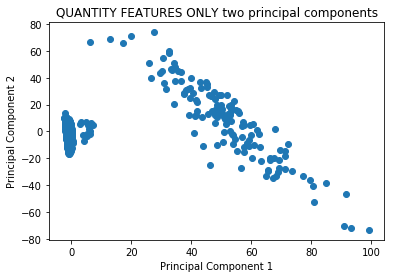

In [8]:
pca_2d = decomposition.PCA(n_components=2)
pca_quant_2d=pca_2d.fit_transform(data_quant)

plt.scatter(pca_quant_2d[:,0],pca_quant_2d[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('QUANTITY FEATURES ONLY two principal components')
plt.show()

## Finding the optimal number of principal components for each three data frames

It's easier to talk about in person, but the best way to determine the optimal number of principal components is to plot the 'cummulative eigenvalue fraction' vs the number of eigenvalues. The code to do this is below. The example code is for 500 principal components - this is way too many. I'll explain why below:


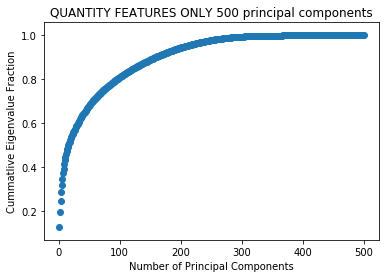

In [9]:
# PCA for 500 components
pca_500d = decomposition.PCA(n_components=500)
pca_quant_500d=pca_500d.fit_transform(data_quant)

# Calculate the cummalative eigenvalue fraction
eigen_fraction_500d=np.cumsum(pca_500d.explained_variance_)/(np.sum(pca_500d.explained_variance_))
#Plot the Results
plt.scatter(range(1,len(pca_500d.explained_variance_)+1),eigen_fraction_500d)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cummatlive Eigenvalue Fraction')
plt.title('QUANTITY FEATURES ONLY 500 principal components')
plt.show()

## Do you see how the plot is flat for most of it? It means 500 is way too many principal components. The optimal number of Principal components is when the above plot only starts to get flat. Copy and paste the code below to find the optimal number of Principal Components for all three data frames:

* Quantitative Features Only
* Quantitative + Categorical Features
* All Features

#### Hint

This is not as hard as it looks. You can reduce the number of principal components in the above plot (to say 150 or so) and pick out the optimal number of components by eye. 

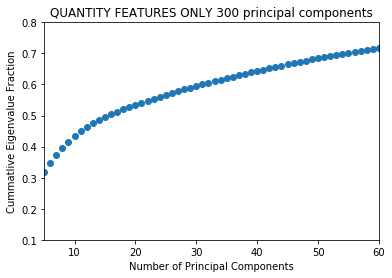

In [10]:
# PCA for 300 components

pca_300d = decomposition.PCA(n_components=300)
pca_quant_300d=pca_300d.fit_transform(data_quant)

# Calculate the cummalative eigenvalue fraction
eigen_fraction_300d=np.cumsum(pca_300d.explained_variance_)/(np.sum(pca_300d.explained_variance_))
#Plot the Results
plt.scatter(range(1,len(pca_300d.explained_variance_)+1),eigen_fraction_300d)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cummatlive Eigenvalue Fraction')
plt.xlim(5,60)
plt.ylim(0.1,0.8)
plt.title('QUANTITY FEATURES ONLY 300 principal components')
plt.show()

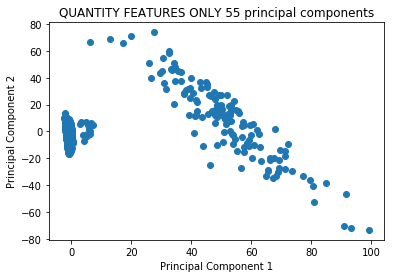

In [11]:
pca_55d = decomposition.PCA(n_components=55)
pca_quant_55d=pca_55d.fit_transform(data_quant)

plt.scatter(pca_quant_55d[:,0],pca_quant_55d[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('QUANTITY FEATURES ONLY 55 principal components')
plt.show()

# Step 3: Dimensionality Reduction with tSNE

This part is straightforward. You will have to run the same code below and replace the number of dimensions with the optimal number of principal components you found above. You will have to do so again for all three data frames

In [12]:
'''tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                     learning_rate=300, n_iter=400)
    #tsne = manifold.TSNE(n_components=2, init='pca')
tsne_quant_2d=tsne_2d.fit_transform(data_quant)

plt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('QUANTITY FEATURES ONLY tSNE with two components')
plt.show()
'''


"tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,\n                     learning_rate=300, n_iter=400)\n    #tsne = manifold.TSNE(n_components=2, init='pca')\ntsne_quant_2d=tsne_2d.fit_transform(data_quant)\n\nplt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])\n\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.title('QUANTITY FEATURES ONLY tSNE with two components')\nplt.show()\n"

In [13]:
"""tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,
                     learning_rate=300, n_iter=400)
    #tsne = manifold.TSNE(n_components=2, init='pca')
tsne_quant_2d=tsne_2d.fit_transform(pca_quant_55d)

plt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('QUANTITY FEATURES ONLY tSNE with two components')
plt.show()
"""

"tsne_2d = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=20,\n                     learning_rate=300, n_iter=400)\n    #tsne = manifold.TSNE(n_components=2, init='pca')\ntsne_quant_2d=tsne_2d.fit_transform(pca_quant_55d)\n\nplt.scatter(tsne_quant_2d[:,0],tsne_quant_2d[:,1])\n\nplt.xlabel('Dimension 1')\nplt.ylabel('Dimension 2')\nplt.title('QUANTITY FEATURES ONLY tSNE with two components')\nplt.show()\n"

# Step 4 - kMeans Clustering

We will have to do kMeans clustering on the data frame with quantitative features only, on the PCA transformed data. We will do kMeans on two different inputs:

* Two principal components 
* The optimal number of principal components (55)


## 2 principal component kMeans

From the PCA plots above, it looks like there are three clusters, possibly 4. A tSNE visualization on the PCA output would give us a better idea how many clusters there are likely to be. To perform kMeans clustering, you must perform the following steps:

* Run kMeans with the parameters n_init=15 and max_iter=400 on the 2-dimensional PCA output to find 3 clusters. Look at the documentation in http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html and https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
* Visualize the resulsting clusters on the 2-dimensional PCA scatter plot above. We want to just reproduce that plot and color the points with which cluster they belong to. Cell #4 in https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html demonstrates how to do this
* We next have to optimize the number of clusters. There are many ways to do this, but using the Silhouette Score to select the best number of clusters is probably the most direct and the fastest: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html and http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score Basically, we want the number of clusters such that the silhouette score (a measure of cluster separation) is as close to 1.0 as possible. Start with 2 clusters, Don't go over 8 clusters. 

## Optimal number (55) principal components

Repeat the above steps, but with 55 principal components. You can't visualize 55 dimensions of course, so just plot the first two principal components of the 55. 

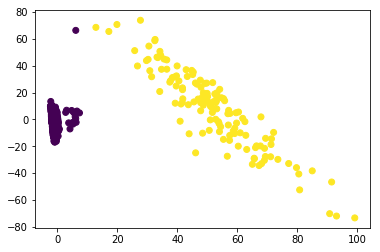

In [14]:
X = pca_quant_55d
kmeans = KMeans(n_clusters=2, n_init=15, max_iter=400).fit(X)
y_pred = kmeans.predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred)

In [15]:
len(y_pred)

5000

0.6863662741264069


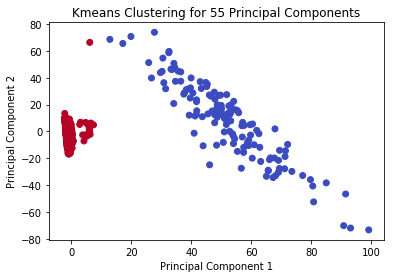

In [16]:
X = pca_quant_55d
kmeans = KMeans(n_clusters=2, n_init=15, max_iter=400)
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels = kmeans.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(silhouette_avg)
plt.scatter(X[:,0], X[:,1], c=cluster_labels, cmap="coolwarm")
plt.title("Kmeans Clustering for 55 Principal Components")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
#plt.savefig('kmeans_55d_scatterplot.png')

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth

X = pca_quant_55d
n=2
#clusterer = KMeans(n_clusters=n, random_state=1
clusterer = AgglomerativeClustering(n_clusters=n,linkage='average',affinity='l1')

cluster_labels = clusterer.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print(silhouette_avg)
plt.scatter(X[:,0], X[:,1], c=cluster_labels)
plt.show()

# Step 5 - find which features contribute the most to PCA. 

In [17]:
## which variables change the data the most/ have the highest variance 

/local/apps/wakari/anaconda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


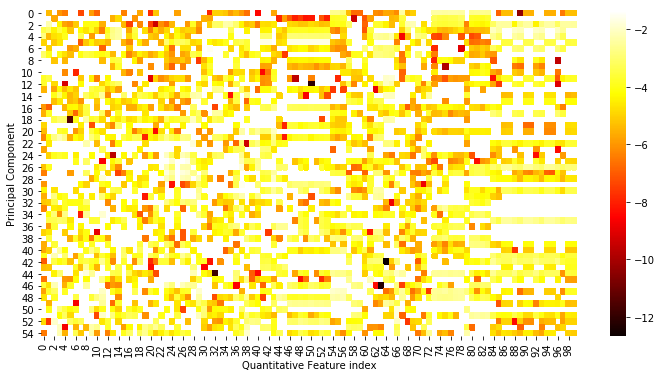

In [18]:
import seaborn as sns
plt.rcParams['figure.figsize']=(12,6)

sns.heatmap(np.log(pca_55d.inverse_transform(np.eye(pca_quant_55d.shape[1])))[:,0:100], cmap="hot", cbar=True)
plt.ylabel('Principal Component')
plt.xlabel('Quantitative Feature index')
plt.show()

In [19]:
## pale colors are most important 

### The above plot shows a heat map of feature importances. Because we have over 600 quantitative features, I only show 100. There are 55 principal components. The more yellow the heatmap is, the more important the feature is. Let's average over the principal components to get the most important features

In [20]:
log_importances=np.log(pca_55d.inverse_transform(np.eye(pca_quant_55d.shape[1])))

/local/apps/wakari/anaconda/envs/default/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


In [21]:
mean_log_importances=np.apply_along_axis(np.mean,0,np.nan_to_num(log_importances))
print(len(mean_log_importances))

638


In [22]:
mean_log_importances_df=pd.DataFrame(data=mean_log_importances,columns=['importance'])

In [23]:
mean_log_importances_df=mean_log_importances_df.reset_index()
print(mean_log_importances_df.head(15))

    index  importance
0       0   -2.982593
1       1   -2.162948
2       2   -1.907605
3       3   -1.637405
4       4   -2.612217
5       5   -2.105688
6       6   -2.298617
7       7   -2.348412
8       8   -1.534937
9       9   -1.982937
10     10   -2.479340
11     11   -2.144028
12     12   -2.364243
13     13   -2.806970
14     14   -2.202900


### The numpy array above is an array of importances, of length 638. They map back to the original data frame:

In [24]:
print(asthma_df_quant.columns[0],asthma_df_quant.columns[637])

('age', 'specialRequest_QUANT_OA_HES_based_age_of_onset')


In [25]:
## every entry in array, can get variabe name 

# Find the ten most important features to start, including their names, to focus on. 

In [26]:
## labels 0-638: have value associated. 
## output array as csv file -- find 10 highest values in the array and associated array index number 

#np.savetxt("Asthma Important Features.csv", mean_log_importances_df, delimiter=",")

In [27]:
asthma_df_important_features = mean_log_importances_df.sort_values(by="importance", ascending=False)
print(asthma_df_important_features.head(15))

     index  importance
368    368   -1.169289
481    481   -1.207705
509    509   -1.333142
45      45   -1.360170
284    284   -1.372095
508    508   -1.380811
350    350   -1.384336
477    477   -1.415512
357    357   -1.419659
405    405   -1.436403
628    628   -1.437946
247    247   -1.440160
285    285   -1.450664
222    222   -1.454610
246    246   -1.454698


# Step 6: ANOVA of the ten most important features between the two clusters

In [28]:
# Add the group label to the data frame:
asthma_df_quant['Cluster Label']=y_pred
asthma_df_quant['Cluster Label']=asthma_df_quant['Cluster Label'].apply(str).apply(lambda x: x.replace('0','A')).apply(lambda x: x.replace('1','B'))

In [29]:
asthma_df_quant.shape

(5000, 639)

### adding the cluster labels allows you to visualize box plots broken down by cluster easily. For example, for age:

In [30]:
## include box plots for top 10 variables 

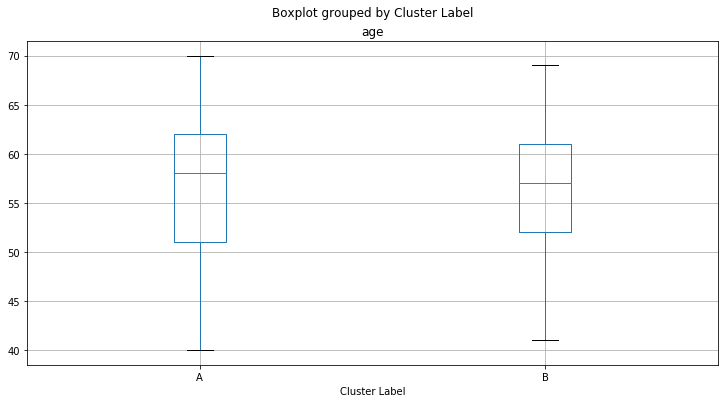

In [31]:
asthma_df_quant.boxplot(asthma_df_quant.columns[0],by='Cluster Label')

In [32]:
v = asthma_df_important_features['index'].values[0]

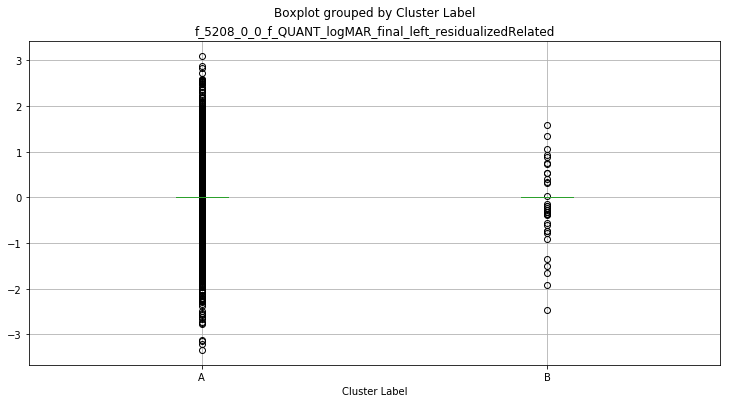

In [33]:
asthma_df_quant.boxplot(asthma_df_quant.columns[v],by='Cluster Label')

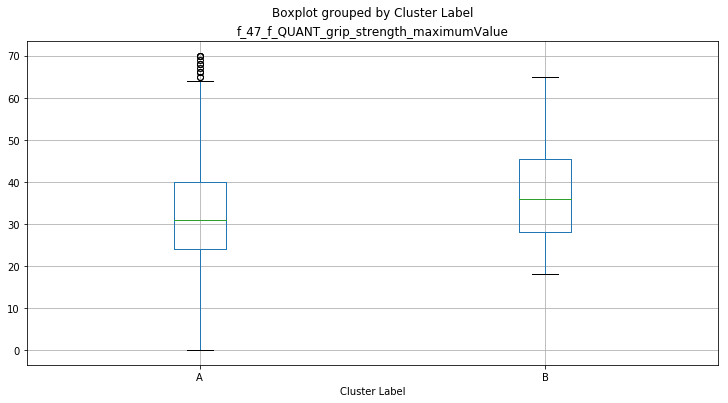

In [34]:
asthma_df_quant.boxplot(asthma_df_quant.columns[237],by='Cluster Label')

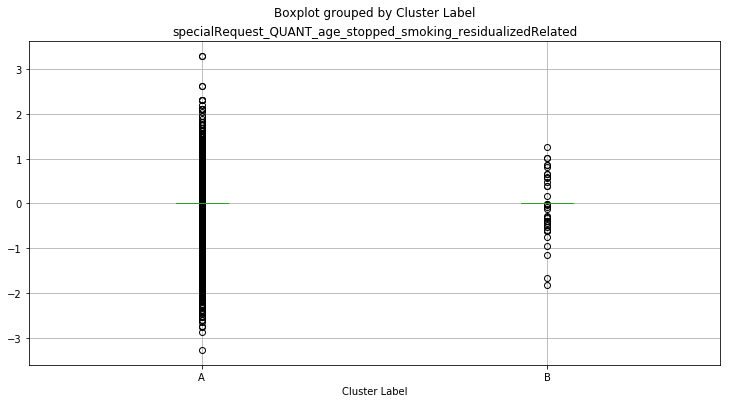

In [35]:
asthma_df_quant.boxplot(asthma_df_quant.columns[632],by='Cluster Label')

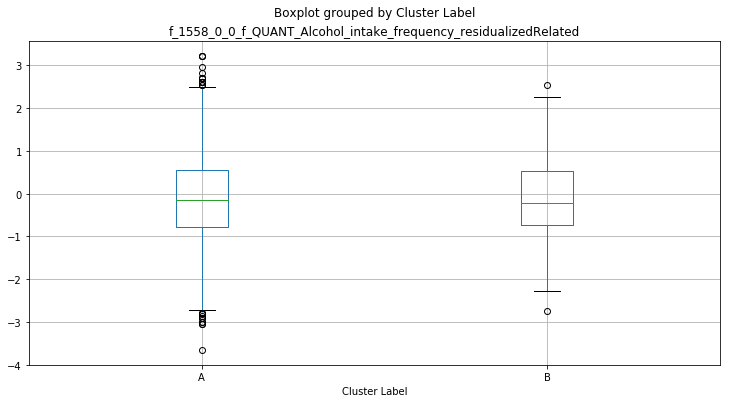

In [36]:
asthma_df_quant.boxplot(asthma_df_quant.columns[332],by='Cluster Label')

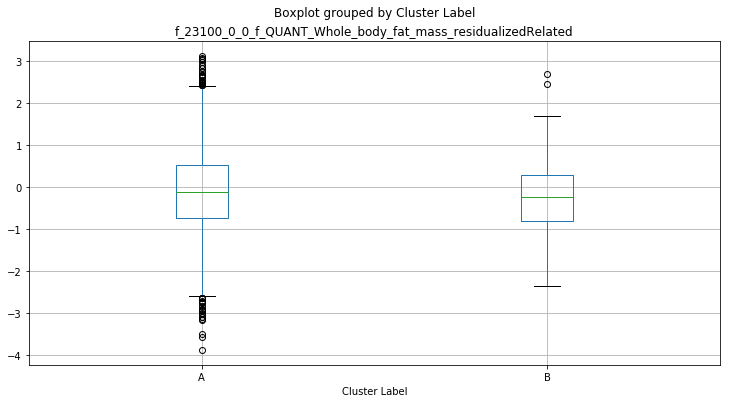

In [37]:
asthma_df_quant.boxplot(asthma_df_quant.columns[413],by='Cluster Label')

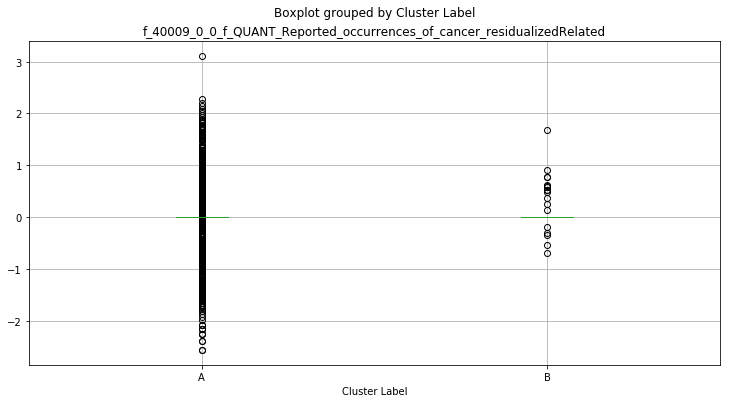

In [38]:
asthma_df_quant.boxplot(asthma_df_quant.columns[549],by='Cluster Label')

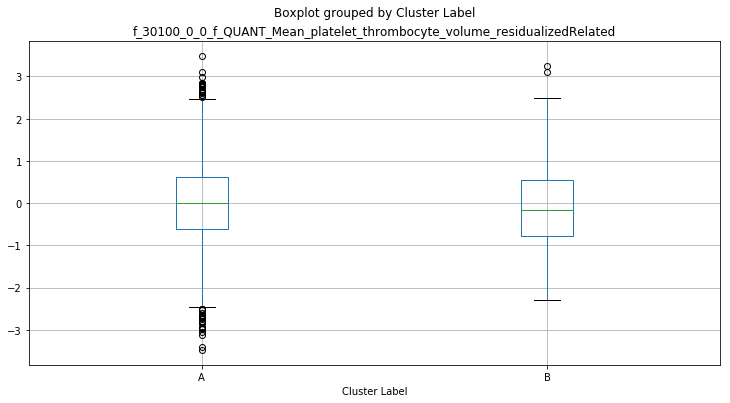

In [39]:
asthma_df_quant.boxplot(asthma_df_quant.columns[524],by='Cluster Label')

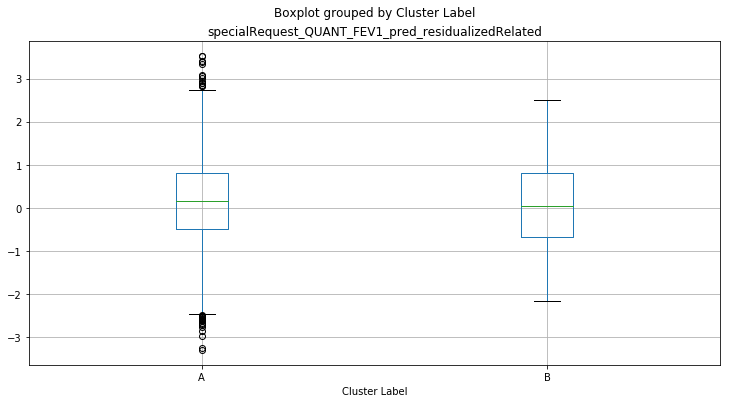

In [40]:
asthma_df_quant.boxplot(asthma_df_quant.columns[621],by='Cluster Label')

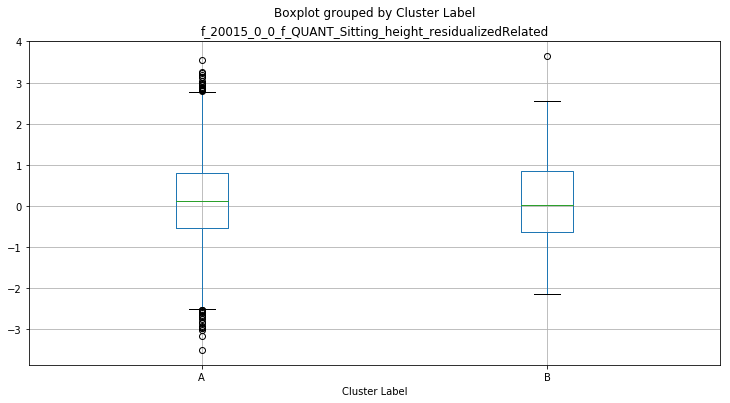

In [41]:
asthma_df_quant.boxplot(asthma_df_quant.columns[380],by='Cluster Label')

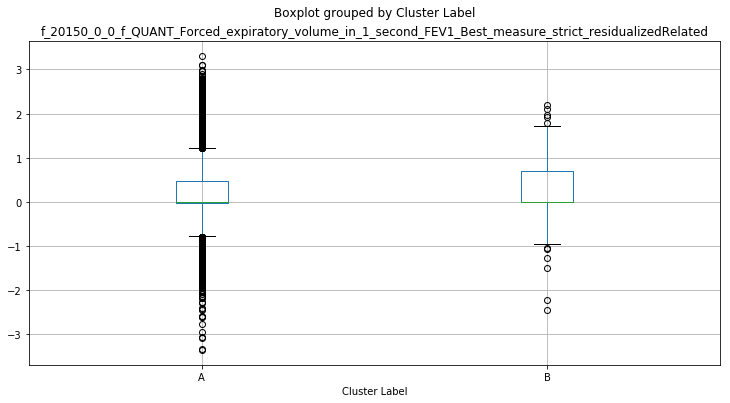

In [42]:
asthma_df_quant.boxplot(asthma_df_quant.columns[590],by='Cluster Label')

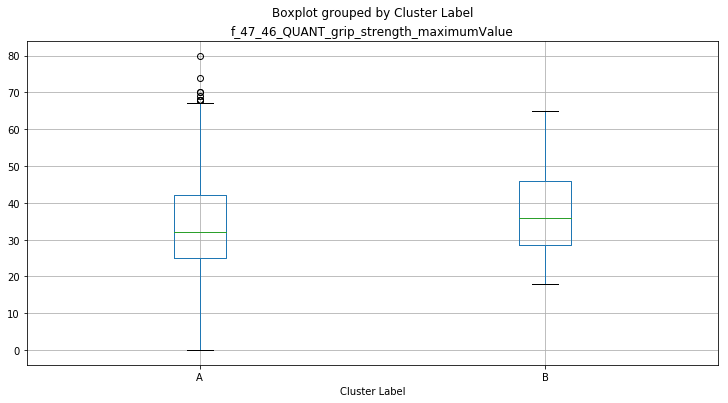

In [43]:
asthma_df_quant.boxplot(asthma_df_quant.columns[238],by='Cluster Label')

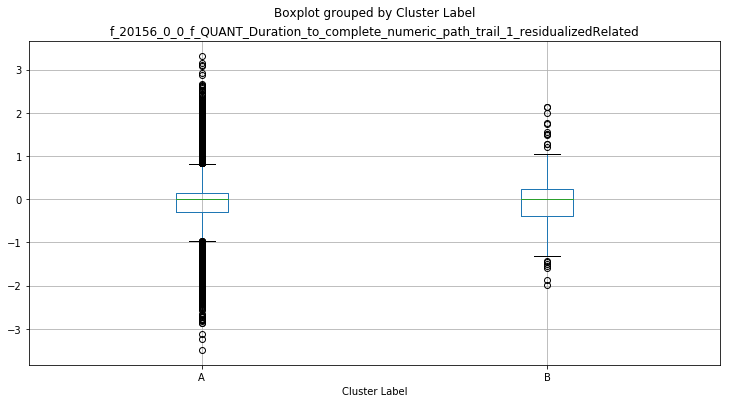

In [44]:
asthma_df_quant.boxplot(asthma_df_quant.columns[554],by='Cluster Label')

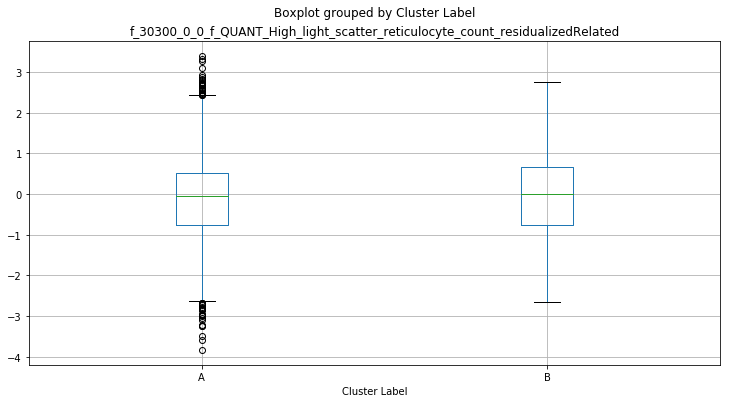

In [45]:
asthma_df_quant.boxplot(asthma_df_quant.columns[544],by='Cluster Label')

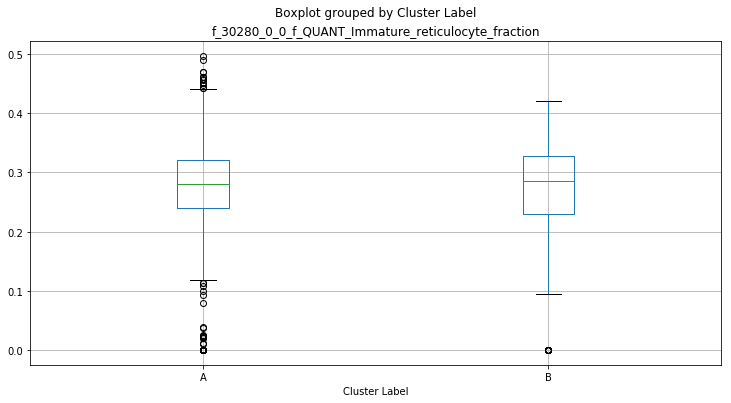

In [46]:
asthma_df_quant.boxplot(asthma_df_quant.columns[214],by='Cluster Label')

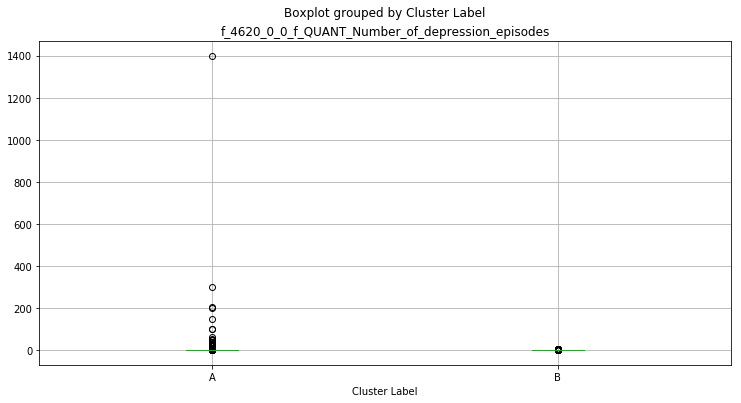

In [47]:
asthma_df_quant.boxplot(asthma_df_quant.columns[24],by='Cluster Label')

### which means the Data is not clustering by age. 

1) Visualize the data in box plots for all ten most important features
2) Run ANOVA on the ten most important features above to derive p-values. Good resources for ANOVA in Python include: https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/ (first section with SciPy only) 

and

https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.f_oneway.html



# ANOVA - analyzes groups of data (group A vs B) to quantify how different they are 
## do each variable separately - 15 different ANOVA's
## lower the better p-value. we define the cutoff ( < 0.05)

In [48]:
asthma_df_quant_group1 = asthma_df_quant[asthma_df_quant['Cluster Label'].str.contains('A')]

asthma_df_quant_group2 = asthma_df_quant[asthma_df_quant['Cluster Label'].str.contains('B')]

In [49]:
[asthma_df_quant.columns[381]]


['f_20016_0_0_f_QUANT_Fluid_intelligence_score_residualizedRelated']

In [50]:
import scipy.stats as stats

feature = asthma_df_quant.columns[381]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))
## if pvalue < 0.05:

   

ANOVA Statistic 0.31831500983974526 and p-value 0.5726473422364362


In [51]:
feature = asthma_df_quant.columns[237]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 12.04689871911725 and p-value 0.0005231738357669493


In [52]:
feature = asthma_df_quant.columns[632]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 1.1834504637868137 and p-value 0.2767071237150174


In [53]:
feature = asthma_df_quant.columns[332]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.07210132887798207 and p-value 0.7883125454589924


In [54]:
[asthma_df_quant.columns[413]]

['f_23100_0_0_f_QUANT_Whole_body_fat_mass_residualizedRelated']

In [55]:
feature = asthma_df_quant.columns[413]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 1.6128812174203702 and p-value 0.2041463861892404


In [56]:
feature = asthma_df_quant.columns[549]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 2.960903996480184 and p-value 0.08536213034277715


In [57]:
feature = asthma_df_quant.columns[524]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 2.311392394867185 and p-value 0.12849221555623164


In [58]:
feature = asthma_df_quant.columns[621]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.1631532023013307 and p-value 0.686287158808281


In [59]:
[asthma_df_quant.columns[380]]

['f_20015_0_0_f_QUANT_Sitting_height_residualizedRelated']

In [60]:
feature = asthma_df_quant.columns[380]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.20939328522296596 and p-value 0.6472632476350051


In [61]:
[asthma_df_quant.columns[590]]

['f_20150_0_0_f_QUANT_Forced_expiratory_volume_in_1_second_FEV1_Best_measure_strict_residualizedRelated']

In [62]:
feature = asthma_df_quant.columns[590]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 1.6592719049809435 and p-value 0.1977612900041745


In [63]:
feature = asthma_df_quant.columns[238]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 11.591183543017596 and p-value 0.0006678675073058919


In [64]:
feature = asthma_df_quant.columns[554]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.019477672016201947 and p-value 0.8890113494033246


In [65]:
feature = asthma_df_quant.columns[544]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.19546659988975806 and p-value 0.6584243614559202


In [66]:
feature = asthma_df_quant.columns[214]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.18236443638243874 and p-value 0.66936750100414


In [67]:
feature = asthma_df_quant.columns[24]
(statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    
print("ANOVA Statistic " + str(statistic) + " and p-value " + str(pvalue))

ANOVA Statistic 0.12264393575366357 and p-value 0.7261991900201507


In [68]:
asthma_df.columns

Index([u'FID', u'IID', u'RGC_ID', u'random_normal', u'random_binary', u'sex',
       u'chip', u'age', u'BMI', u'asthma',
       ...
       u'f_40019_0_p_D40_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_male_genital_organs',
       u'f_40019_0_p_D41_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_urinary_organs',
       u'f_40019_0_p_D42_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_meninges',
       u'f_40019_0_p_D43_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_brain_and_CNS',
       u'f_40019_0_p_D44_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_endocrine_glands',
       u'f_40019_0_p_D45_CAT_Polycythaemia_vera',
       u'f_40019_0_p_D46_CAT_Myelodysplastic_syndromes',
       u'f_40019_0_p_D47_CAT_Other_neoplasms_of_uncertain_behaviour_of_lymphoid_haematopoietic',
       u'f_40019_0_p_D48_CAT_Neoplasm_of_uncertain_or_unknown_behaviour_of_other_sites',
       u'f_40019_0_p_O01_CAT_Hydatidiform_mole'],
      dtype='object', length=5172)

In [69]:
asthma_df_2=pd.read_csv("ukbb_asthma_sample_5k_new.csv",sep='\t')

In [70]:
for x in asthma_df_2.columns :
    if 'asthma' in x:
        print x

asthma
f_3786_0_0_f_QUANT_Age_asthma_diagnosed
f_22147_0_0_f_QUANT_Age_asthma_diagnosed_by_doctor
f_20009_0_dxAgeCode1111_QUANT_asthma
f_3786_0_0_f_QUANT_Age_asthma_diagnosed_residualizedRelated
f_22147_0_0_f_QUANT_Age_asthma_diagnosed_by_doctor_residualizedRelated
f_20009_0_dxAgeCode1111_QUANT_asthma_residualizedRelated
specialRequest_QUANT_type_of_asthma_exacerbation
specialRequest_QUANT_asthma_hospital_exacerbations_raw
specialRequest_QUANT_asthma_hospital_exacerbations_annual_rate
specialRequest_QUANT_asthma_HES_based_age_of_onset
specialRequest_QUANT_asthma_HES_or_NI_based_age_of_onset_youngest
f_22127_0_0_f_BIN_Doctor_diagnosed_asthma
f_22167_0_0_f_BIN_Recent_medication_for_asthma
f_20002_0_dxCode1111_BIN_asthma
HES_p_J46_BIN_Status_asthmaticus
HES_primary_p_J46_BIN_Status_asthmaticus
map2way_NI_code1111_BIN_asthma
specialRequest_BIN_NI_pediatric_asthma_under16yo
specialRequest_BIN_NI_adult_only_asthma_over16yo


In [71]:
asthma_df_2['f_22127_0_0_f_BIN_Doctor_diagnosed_asthma'].value_counts()

1.0    1194
0.0     158
Name: f_22127_0_0_f_BIN_Doctor_diagnosed_asthma, dtype: int64

In [72]:
print('hello')

hello


In [73]:
p_values=[]
features=list(asthma_df_quant_group1.columns.values[:-1])
anova_dict=dict()

for feature in asthma_df_quant_group1.columns.values[:-1]:
    (statistic, pvalue) = stats.f_oneway(asthma_df_quant_group1[feature].values, asthma_df_quant_group2[feature].values)
    p_values.append(pvalue)
anova_dict['feature']=features
anova_dict['pvalue']=p_values
anova_df=pd.DataFrame.from_dict(anova_dict)

In [74]:
anova_df=anova_df.sort_values(by='pvalue')
threshold=0.05
anova_df_significant=anova_df.loc[(anova_df.pvalue < threshold) & (anova_df.pvalue > 0)].sort_values(by='pvalue')

In [75]:
anova_df_significant.tail(50)

,feature,pvalue
405,f_22424_2_0_f_QUANT_Cardiac_output_residualize...,1.825525e-07
379,f_12702_2_0_f_QUANT_Cardiac_index_during_PWA_r...,1.961590e-07
378,f_12340_2_0_f_QUANT_QRS_duration_residualizedR...,7.207754e-07
605,specialRequest_QUANT_LVESVi_residualizedRelated,5.638355e-06
488,f_23279_2_0_f_QUANT_Total_fat_free_mass_residu...,4.449092e-05
567,f_47_46_QUANT_grip_strength_maximumValue_resid...,5.065731e-05
566,f_47_f_QUANT_grip_strength_maximumValue_residu...,6.664593e-05
456,f_23247_2_0_f_QUANT_Android_tissue_fat_percent...,7.680038e-05
495,f_23286_2_0_f_QUANT_Trunk_tissue_fat_percentag...,1.372156e-04
472,f_23263_2_0_f_QUANT_Gynoid_lean_mass_residuali...,2.086299e-04


In [80]:
anova_df_significant[anova_df_significant['feature'].str.contains('FEV|FVC')].shape

(3, 2)

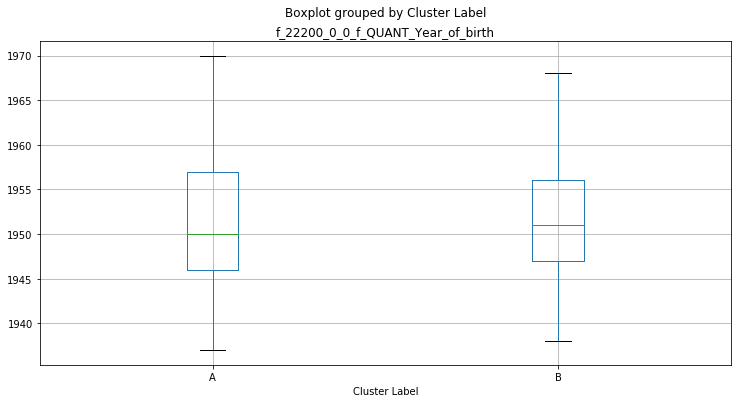

In [76]:
asthma_df_quant.boxplot('f_22200_0_0_f_QUANT_Year_of_birth',by='Cluster Label')